# Comorbid Condition Classifier

### Prepare Data

In [1]:
import sys
sys.path.append("..")
import numpy as np
import sklearn as sk
from sklearn.metrics import classification_report
import torch
from torch import nn, cuda
import matplotlib.pyplot as plt
import prepare_data
from prepare_data import DataPreparationContext
from prepare_data import ClassEmbedders
import models
from models import GenericMutliClassifier

In [2]:
def embedder(diseases, classes, classes_lookup):
    if len(diseases) < 2:
        return None
    else:
        return ClassEmbedders.match_exact(diseases, classes, classes_lookup)
    
data_context = DataPreparationContext(combine_riskiest=16, verbose=True, classes=prepare_data.CLASSES_COMORBID, class_embedder=embedder)

training_data = data_context.prepare_from_file("../../symptom_sum_top16/train.pkl", oversample=True)
X_train_np = training_data['X']
y_train_np = training_data['y']

validation_data = data_context.prepare_from_file("../../symptom_sum_top16/val.pkl", oversample=False)
X_val_np = validation_data['X']
y_val_np = validation_data['y']



100%|██████████| 21300/21300 [00:00<00:00, 98666.84it/s]


Input File: ../../symptom_sum_top16/train.pkl
 [anxiety depression] has 310
 [depression ptsd] has 310
 [anxiety depression ptsd] has 310
 [anxiety ptsd] has 310



100%|██████████| 2662/2662 [00:00<00:00, 106543.61it/s]

Input File: ../../symptom_sum_top16/val.pkl
 [anxiety depression] has 44
 [depression ptsd] has 2
 [anxiety depression ptsd] has 7
 [anxiety ptsd] has 3



## Deep Learning

### Convert to Tensors

In [3]:
X_train = models.convert_to_tensors(X_train_np).type(torch.float32).to(models.device)
y_train = models.convert_to_tensors(y_train_np).type(torch.LongTensor).to(models.device)
X_val = models.convert_to_tensors(X_val_np).type(torch.float32).to(models.device)
y_val = models.convert_to_tensors(y_val_np).type(torch.LongTensor).to(models.device)

### Define Model

The models used are based on tutorial:
```
Bourke , D 2022, PyTorch for Deep Learning & Machine Learning – Full Course, in freeCodeCamp.org (ed.), YouTube, viewed 6 May 2024, <https://www.youtube.com/watch?v=V_xro1bcAuA>.
```

### Train Model

Epoch: 500 | Loss: 0.06827, Acc: 99.19%, Val Acc: 71.43%
                         precision    recall  f1-score   support

     anxiety depression       0.78      0.89      0.83        44
        depression ptsd       0.00      0.00      0.00         2
           anxiety ptsd       0.00      0.00      0.00         3
anxiety depression ptsd       0.00      0.00      0.00         7

               accuracy                           0.70        56
              macro avg       0.20      0.22      0.21        56
           weighted avg       0.61      0.70      0.65        56



c:\Users\nstan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nstan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nstan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

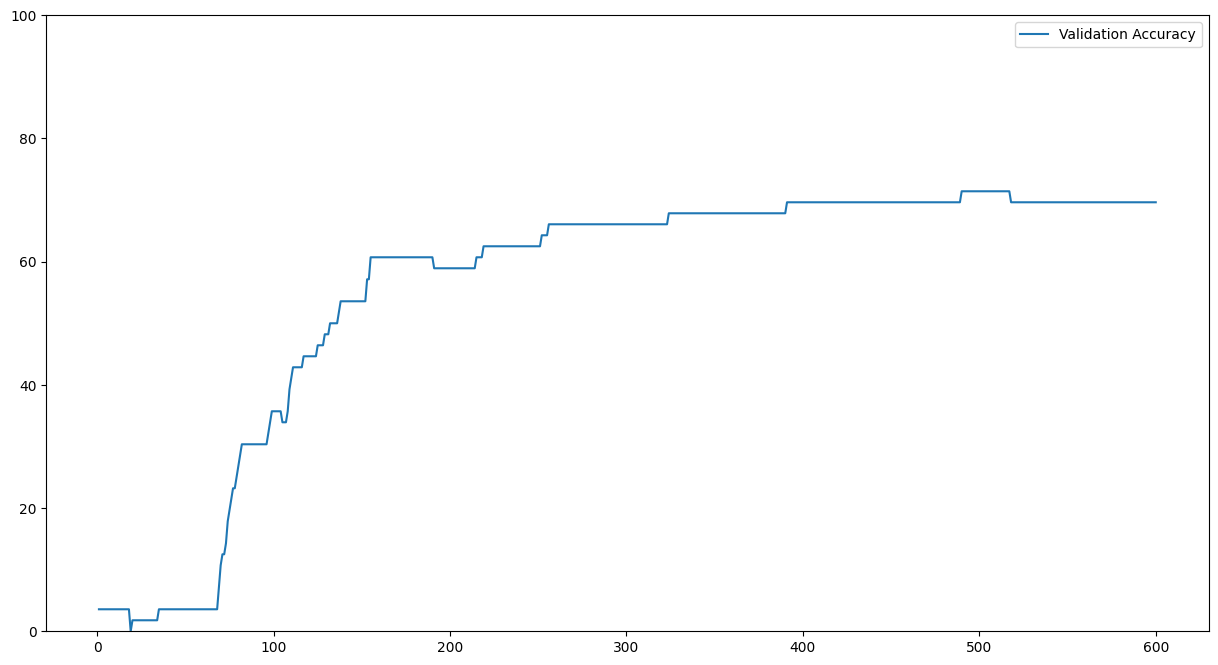

In [8]:
models.begin_plot()

hidden_layers = 250
epochs = 600
learning_rate = 0.0001
labels = [(' '.join(x) if len(' '.join(x)) != 0 else 'healthy') for x in prepare_data.CLASSES_COMORBID.values()]

model = models.GenericMutliClassifier(input_features=X_train.shape[1], output_features=8, hidden_units=hidden_layers, report_labels=labels).to(models.device)
report = model.train_model(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=epochs,
    learning_rate=learning_rate,
    should_print=True,
    should_plot=True,
    plot_label="Validation Accuracy",
    analysis_interval=1
)
print(report)
models.finish_plot()


### Save Model

In [9]:
model.save_model("3-comorbid-codition-multiclassifier.pth")